## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras
import tensorflow as tf
from keras.regularizers import l1, l2, l1_l2

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)  
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))  

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
# L1
def build_mlp_l1(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [5]:
# L2
def build_mlp_l2(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [5]:
# L1_L2
def build_mlp_l1l2(input_shape, output_units=10, num_neurons=[512, 256, 128], l1l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
L1L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [9]:
# L1
results = {}
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0717 13:21:50.140889 22392 deprecation_wrapper.py:119] From C:\Users\vince\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0717 13:21:50.141885 22392 deprecation_wrapper.py:119] From C:\Users\vince\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0717 13:21:50.145874 22392 deprecation_wrapper.py:119] From C:\Users\vince\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0717 13:21:50.145874 22392 deprecation_wrapper.py:119] From C:\Users\vince\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0717 13:21:50.148868 22392 

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W0717 13:21:50.360176 22392 deprecation.py:323] From C:\Users\vince\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 77us/step - loss: 198.7992 - acc: 0.2359 - val_loss: 41.2777 - val_acc: 0.2500
Epoch 2/50
50000/50000 [==============================] - 3s 61us/step - loss: 19.2256 - acc: 0.1141 - val_loss: 7.3440 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 3s 64us/step - loss: 4.1349 - acc: 0.1000 - val_loss: 2.6518 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 3s 59us/step - loss: 2.4868 - acc: 0.0984 - val_loss: 2.4623 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 3s 63us/step - loss: 2.4626 - acc: 0.0987 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 3s 62us/step - loss: 2.4626 - acc: 0.0954 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 3s 66us/step - loss: 2.4626 - acc: 0.0980 - val_loss: 2.4624 - val

50000/50000 [==============================] - 3s 59us/step - loss: 5.7044 - acc: 0.3689 - val_loss: 5.6413 - val_acc: 0.3771
Epoch 3/50
50000/50000 [==============================] - 3s 58us/step - loss: 5.5619 - acc: 0.3978 - val_loss: 5.5034 - val_acc: 0.4135
Epoch 4/50
50000/50000 [==============================] - 3s 59us/step - loss: 5.4447 - acc: 0.4188 - val_loss: 5.3965 - val_acc: 0.4221
Epoch 5/50
50000/50000 [==============================] - 3s 59us/step - loss: 5.3378 - acc: 0.4334 - val_loss: 5.3003 - val_acc: 0.4301
Epoch 6/50
50000/50000 [==============================] - 3s 59us/step - loss: 5.2388 - acc: 0.4443 - val_loss: 5.1999 - val_acc: 0.4427
Epoch 7/50
50000/50000 [==============================] - 3s 59us/step - loss: 5.1462 - acc: 0.4554 - val_loss: 5.1231 - val_acc: 0.4419
Epoch 8/50
50000/50000 [==============================] - 3s 59us/step - loss: 5.0566 - acc: 0.4655 - val_loss: 5.0442 - val_acc: 0.4518
Epoch 9/50
50000/50000 [============================

50000/50000 [==============================] - 3s 61us/step - loss: 1.7191 - acc: 0.3975 - val_loss: 1.6864 - val_acc: 0.4083
Epoch 4/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.6609 - acc: 0.4170 - val_loss: 1.6313 - val_acc: 0.4326
Epoch 5/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.6148 - acc: 0.4333 - val_loss: 1.5956 - val_acc: 0.4441
Epoch 6/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.5757 - acc: 0.4471 - val_loss: 1.5773 - val_acc: 0.4352
Epoch 7/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.5422 - acc: 0.4586 - val_loss: 1.5428 - val_acc: 0.4526
Epoch 8/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.5128 - acc: 0.4692 - val_loss: 1.5335 - val_acc: 0.4579
Epoch 9/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.4852 - acc: 0.4797 - val_loss: 1.5099 - val_acc: 0.4640
Epoch 10/50
50000/50000 [===========================

50000/50000 [==============================] - 3s 59us/step - loss: 1.6796 - acc: 0.4140 - val_loss: 1.6498 - val_acc: 0.4243
Epoch 5/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.6298 - acc: 0.4311 - val_loss: 1.6058 - val_acc: 0.4360
Epoch 6/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.5892 - acc: 0.4437 - val_loss: 1.5774 - val_acc: 0.4445
Epoch 7/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.5544 - acc: 0.4563 - val_loss: 1.5519 - val_acc: 0.4542
Epoch 8/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.5241 - acc: 0.4684 - val_loss: 1.5447 - val_acc: 0.4461
Epoch 9/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.4972 - acc: 0.4760 - val_loss: 1.5041 - val_acc: 0.4683
Epoch 10/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.4721 - acc: 0.4840 - val_loss: 1.5009 - val_acc: 0.4645
Epoch 11/50
50000/50000 [==========================

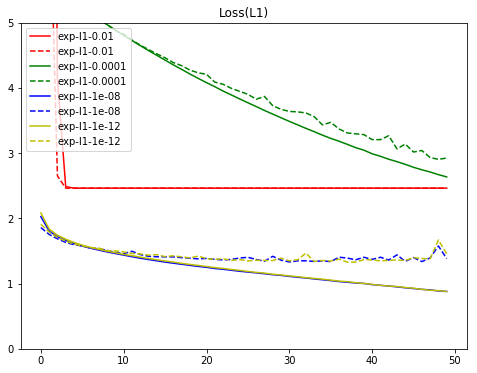

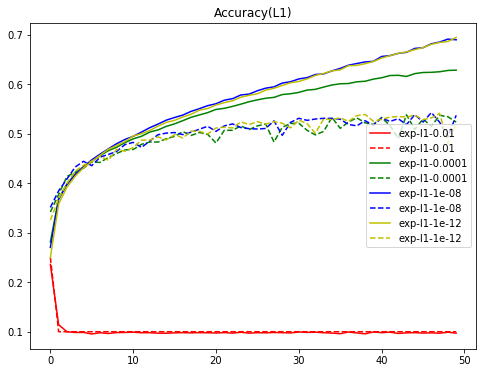

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss(L1)")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy(L1)")
plt.legend()
plt.show()

In [7]:
# L2
results = {}
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l2(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0717 13:34:08.659563 20100 deprecation_wrapper.py:119] From C:\Users\vince\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0717 13:34:08.660534 20100 deprecation_wrapper.py:119] From C:\Users\vince\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0717 13:34:08.664524 20100 deprecation_wrapper.py:119] From C:\Users\vince\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0717 13:34:08.665524 20100 deprecation_wrapper.py:119] From C:\Users\vince\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0717 13:34:08.668514 20100 

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W0717 13:34:08.926854 20100 deprecation.py:323] From C:\Users\vince\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 85us/step - loss: 15.0768 - acc: 0.2639 - val_loss: 13.9463 - val_acc: 0.3339
Epoch 2/50
50000/50000 [==============================] - 3s 67us/step - loss: 13.0178 - acc: 0.3516 - val_loss: 12.1256 - val_acc: 0.3703
Epoch 3/50
50000/50000 [==============================] - 3s 67us/step - loss: 11.3480 - acc: 0.3746 - val_loss: 10.5943 - val_acc: 0.3831
Epoch 4/50
50000/50000 [==============================] - 3s 67us/step - loss: 9.9354 - acc: 0.3894 - val_loss: 9.3005 - val_acc: 0.3960
Epoch 5/50
50000/50000 [==============================] - 3s 69us/step - loss: 8.7363 - acc: 0.3981 - val_loss: 8.1881 - val_acc: 0.4067
Epoch 6/50
50000/50000 [==============================] - 3s 70us/step - loss: 7.7127 - acc: 0.4080 - val_loss: 7.2503 - val_acc: 0.4062
Epoch 7/50
50000/50000 [==============================] - 3s 68us/step - loss: 6.8398 - acc: 0.4146 - val_loss: 6.4434 - v

50000/50000 [==============================] - 3s 67us/step - loss: 1.9556 - acc: 0.3641 - val_loss: 1.9085 - val_acc: 0.3711
Epoch 3/50
50000/50000 [==============================] - 3s 66us/step - loss: 1.8684 - acc: 0.3970 - val_loss: 1.8369 - val_acc: 0.4059
Epoch 4/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.8063 - acc: 0.4181 - val_loss: 1.7912 - val_acc: 0.4186
Epoch 5/50
50000/50000 [==============================] - 3s 67us/step - loss: 1.7603 - acc: 0.4336 - val_loss: 1.7407 - val_acc: 0.4406
Epoch 6/50
50000/50000 [==============================] - 3s 68us/step - loss: 1.7196 - acc: 0.4480 - val_loss: 1.7236 - val_acc: 0.4436
Epoch 7/50
50000/50000 [==============================] - 3s 66us/step - loss: 1.6869 - acc: 0.4596 - val_loss: 1.6885 - val_acc: 0.4522
Epoch 8/50
50000/50000 [==============================] - 3s 69us/step - loss: 1.6549 - acc: 0.4707 - val_loss: 1.6748 - val_acc: 0.4545
Epoch 9/50
50000/50000 [============================

50000/50000 [==============================] - 3s 60us/step - loss: 1.7369 - acc: 0.3906 - val_loss: 1.7052 - val_acc: 0.3988
Epoch 4/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.6791 - acc: 0.4127 - val_loss: 1.6670 - val_acc: 0.4057
Epoch 5/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.6302 - acc: 0.4307 - val_loss: 1.6206 - val_acc: 0.4271
Epoch 6/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.5908 - acc: 0.4442 - val_loss: 1.5810 - val_acc: 0.4441
Epoch 7/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.5550 - acc: 0.4551 - val_loss: 1.5611 - val_acc: 0.4500
Epoch 8/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.5248 - acc: 0.4646 - val_loss: 1.5263 - val_acc: 0.4612
Epoch 9/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.4958 - acc: 0.4760 - val_loss: 1.5117 - val_acc: 0.4691
Epoch 10/50
50000/50000 [===========================

50000/50000 [==============================] - 3s 60us/step - loss: 1.6690 - acc: 0.4150 - val_loss: 1.6504 - val_acc: 0.4210
Epoch 5/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.6215 - acc: 0.4321 - val_loss: 1.6098 - val_acc: 0.4369
Epoch 6/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.5810 - acc: 0.4465 - val_loss: 1.5831 - val_acc: 0.4461
Epoch 7/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.5456 - acc: 0.4590 - val_loss: 1.5521 - val_acc: 0.4500
Epoch 8/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.5152 - acc: 0.4692 - val_loss: 1.5223 - val_acc: 0.4648
Epoch 9/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.4875 - acc: 0.4774 - val_loss: 1.5027 - val_acc: 0.4678
Epoch 10/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.4615 - acc: 0.4874 - val_loss: 1.4833 - val_acc: 0.4730
Epoch 11/50
50000/50000 [==========================

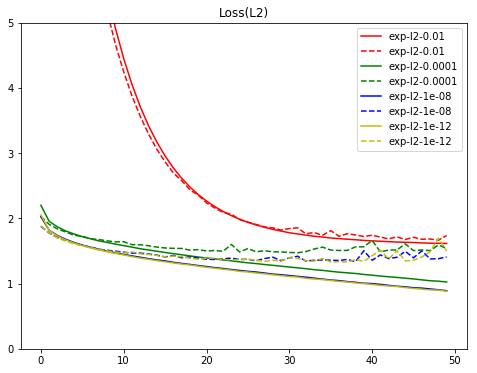

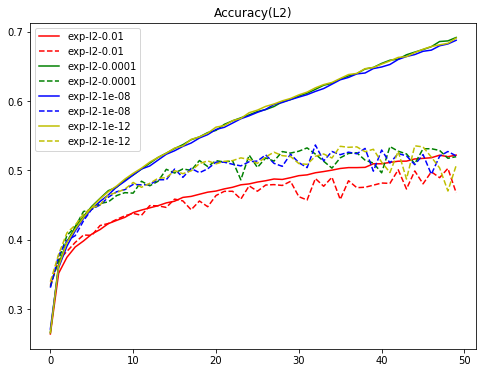

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss(L2)")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy(L2)")
plt.legend()
plt.show()

In [7]:
# L1_L2
results = {}
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1l2(input_shape=x_train.shape[1:], l1l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0717 15:54:48.928338 20104 deprecation_wrapper.py:119] From C:\Users\vince\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0717 15:54:48.929322 20104 deprecation_wrapper.py:119] From C:\Users\vince\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0717 15:54:48.933311 20104 deprecation_wrapper.py:119] From C:\Users\vince\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0717 15:54:48.934309 20104 deprecation_wrapper.py:119] From C:\Users\vince\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0717 15:54:48.937303 20104 

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W0717 15:54:49.272925 20104 deprecation.py:323] From C:\Users\vince\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 86us/step - loss: 197.9190 - acc: 0.2413 - val_loss: 35.9796 - val_acc: 0.2483
Epoch 2/50
50000/50000 [==============================] - 3s 69us/step - loss: 15.9240 - acc: 0.1109 - val_loss: 5.1504 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 3s 69us/step - loss: 3.2194 - acc: 0.0978 - val_loss: 2.4727 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 3s 67us/step - loss: 2.4633 - acc: 0.0989 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 3s 70us/step - loss: 2.4624 - acc: 0.0967 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 3s 69us/step - loss: 2.4624 - acc: 0.0988 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 3s 67us/step - loss: 2.4624 - acc: 0.0985 - val_loss: 2.4624 - val

50000/50000 [==============================] - 3s 69us/step - loss: 16.1645 - acc: 0.3499 - val_loss: 15.0004 - val_acc: 0.3642
Epoch 3/50
50000/50000 [==============================] - 3s 68us/step - loss: 13.9737 - acc: 0.3724 - val_loss: 12.9989 - val_acc: 0.3771
Epoch 4/50
50000/50000 [==============================] - 3s 69us/step - loss: 12.1245 - acc: 0.3872 - val_loss: 11.2895 - val_acc: 0.3940
Epoch 5/50
50000/50000 [==============================] - 3s 69us/step - loss: 10.5503 - acc: 0.3964 - val_loss: 9.8431 - val_acc: 0.3976
Epoch 6/50
50000/50000 [==============================] - 4s 71us/step - loss: 9.2122 - acc: 0.4032 - val_loss: 8.6130 - val_acc: 0.4059
Epoch 7/50
50000/50000 [==============================] - 4s 70us/step - loss: 8.0724 - acc: 0.4104 - val_loss: 7.5528 - val_acc: 0.4132
Epoch 8/50
50000/50000 [==============================] - 4s 71us/step - loss: 7.1005 - acc: 0.4152 - val_loss: 6.6637 - val_acc: 0.4156
Epoch 9/50
50000/50000 [=====================

50000/50000 [==============================] - 4s 70us/step - loss: 11.3433 - acc: 0.3840 - val_loss: 10.5965 - val_acc: 0.3873
Epoch 4/50
50000/50000 [==============================] - 3s 69us/step - loss: 9.9325 - acc: 0.3973 - val_loss: 9.2999 - val_acc: 0.4044
Epoch 5/50
50000/50000 [==============================] - 3s 69us/step - loss: 8.7318 - acc: 0.4080 - val_loss: 8.1945 - val_acc: 0.4122
Epoch 6/50
50000/50000 [==============================] - 3s 70us/step - loss: 7.7092 - acc: 0.4165 - val_loss: 7.2502 - val_acc: 0.4209
Epoch 7/50
50000/50000 [==============================] - 3s 70us/step - loss: 6.8383 - acc: 0.4226 - val_loss: 6.4472 - val_acc: 0.4231
Epoch 8/50
50000/50000 [==============================] - 3s 69us/step - loss: 6.0926 - acc: 0.4285 - val_loss: 5.7645 - val_acc: 0.4260
Epoch 9/50
50000/50000 [==============================] - 3s 69us/step - loss: 5.4565 - acc: 0.4337 - val_loss: 5.1735 - val_acc: 0.4363
Epoch 10/50
50000/50000 [=========================

50000/50000 [==============================] - 3s 68us/step - loss: 9.9136 - acc: 0.4008 - val_loss: 9.2865 - val_acc: 0.3985
Epoch 5/50
50000/50000 [==============================] - 3s 69us/step - loss: 8.7143 - acc: 0.4090 - val_loss: 8.1763 - val_acc: 0.4112
Epoch 6/50
50000/50000 [==============================] - 4s 73us/step - loss: 7.6935 - acc: 0.4179 - val_loss: 7.2293 - val_acc: 0.4282
Epoch 7/50
50000/50000 [==============================] - 4s 71us/step - loss: 6.8222 - acc: 0.4263 - val_loss: 6.4324 - val_acc: 0.4256
Epoch 8/50
50000/50000 [==============================] - 3s 70us/step - loss: 6.0806 - acc: 0.4316 - val_loss: 5.7478 - val_acc: 0.4289
Epoch 9/50
50000/50000 [==============================] - 3s 69us/step - loss: 5.4459 - acc: 0.4367 - val_loss: 5.1753 - val_acc: 0.4378
Epoch 10/50
50000/50000 [==============================] - 3s 67us/step - loss: 4.9060 - acc: 0.4417 - val_loss: 4.6686 - val_acc: 0.4346
Epoch 11/50
50000/50000 [==========================

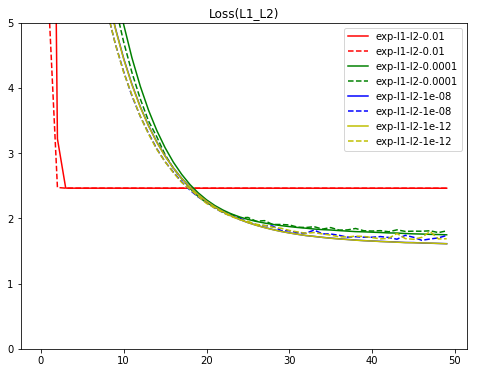

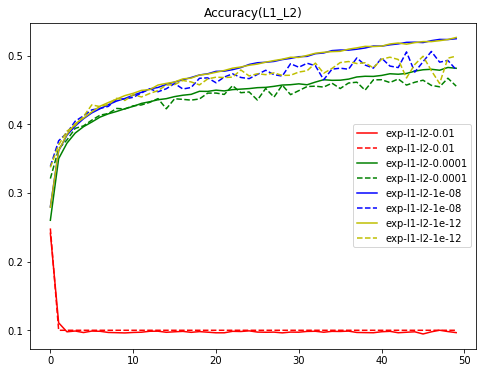

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss(L1_L2)")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy(L1_L2)")
plt.legend()
plt.show()